# Near Real-time Burnt Area Mapping using the DEA datacube
src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook compatible with the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_s2am_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2am_ard_3), 
[ga_s2bm_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2bm_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls9c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls9c_ard_3)

### IMPORTANT: This notebook and the datasets visualised and produced are not to be used for safety of life decisions. For local updates and alerts, please refer to your state emergency or fire service.


## Background

During active fire events, emergency service providers can derive significant value from mapping current/real-time fire extent polygons. This notebook outlines a workflow to assist emergency service employees and volunteers in creating an exportable polygon vector file of unverified brunt areas using the most suitable recent Landsat-8 and Sentinel-2 Imagery of a fire.

### What does 'Near Real-time' Burnt Area Mapping mean?

In this notebook, Near Real-time refers to being able to map the extent of fires as they existed multiple days ago. It does not mean mapping fires as they are currently occurring this instant. This notebook relies on the availability of cloud-free multi-spectral imagery, the most current of which may be multiple days old. There is also no guarantee that suitable imagery will be acquired over any given AOI during a fire event.

The workflow described below uses multi-spectral satellite imagery from the Landsat 8 and 9, and Sentinel 2a and 2b sensors. Each Landsat sensor has a revisit time of 16 days, while each Sentinel sensor has a revisit time of 10 days (spaced 5 days apart resulting in an image taken every 5 days). Ignoring the issue of clouds and smoke occurring over a chosen AOI, these revisit times can give users an idea of temporal possibilities of the 'Near Real-time' mapping described in this notebook.

### When to use this notebook

This notebook is designed to map the extent of fires within Australia over the previous fortnight dependent on the availability of suitable imagery. The output of this notebook does not measure the severity of fires.

For users interested in mapping historical fires, please use the [Burnt Area mapping using Sentinel-2 data notebook.](https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Burnt_area_mapping.html) instead.

### Normalised Burn Ratio (NBR) and delta Normalised Burn Ratio (dNBR)

The Normalised Burn Ratio (NBR) is an index that uses the differences in the way healthy green vegetation and burnt vegetation reflect light to detect burnt pixels in mutli-spectral imagery. The NBR index requires signals from the NIR (Near Infrared) and SWIR (Short-wave Infrared) parts of the electromagnetic spectrum and is defined below.

$$
NBR :\frac{NIR - SWIR}{NIR + SWIR}
$$

Comparing the most-recent NBR values to a baseline or past NBR (i.e. dNBR) can be helpful in identifying burnt areas in dry and less vegetated landscapes.
$$
dNBR: NBR_{baseline} - NBR_{post-fire}
$$

More information on NBR and dNBR can be found in the [Burnt Area mapping using Sentinel-2 data notebook.](https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Burnt_area_mapping.html)

### Relativized Burn Ratio (RBR)
The Relativized Burn Ratio (NBR) is a variation of the Relativized delta Normalised Burn Ratio (RdNBR) developed by [SA parks](https://www.mdpi.com/2072-4292/6/3/1827) that solves some of the numerical problems with the original RdNBR algorithm. Like the RdNBR, the RBR aims to improve Burn Area Mapping over burnt areas that had low levels of pre-fire vegetation by considering the baseline NBR measurement to prevent these areas being thresholded out.
$$
RBR = \frac{dNBR}{(NBR_{baseline} + 1.001)}
$$
Later on in this analysis, you may wish to use the RBR index instead of the dNBR index if your AOI has considerable amounts of burnt area that originally had low vegetation levels. For example, the RBR may work better mapping fires over barren grasslands then the dNBR method.





## Description

This notebook contains the following steps:

**1. Getting Started and Defining an AOI<br>**
    -Load packages<br>
    -Connect to the datacube<br>
	-Select location<br>
**2. Define suitable date ranges for the 'baseline' and 'Near Real-time' Images**<br>
**3. Load, Visualise, and Select a Real-time image<br>**
	-Define Load Parameters¶<br>
	-Load images from the Sentinel-2 collection<br>
	-Load images from the Landsat collection<br>
	-Near Real-time Image Visualisation¶<br>
	-Near Real-time Image Selection<br>
**4. Load and Select baseline Imagery<br>**
    -Visualise the extracted baseline imagery<br>
	-Baseline Image Selection<br>
**5. Calculate NBR and dNBR dataarray's and perform optional post-processing**<br>
    -dNBR vs Relativized NBR for Burnt Area Mapping¶<br>
    -Setting the threshold value to delineate burnt areas<br>
    -Optional: Morphological Post-Processing<br>
**6. Convert raster data to vector and export products**<br>
    -Exporting Rasters<br>
    -Converting the Raster BAM data to Vector format before exporting to shapefile


## 1. Getting started and defining an AOI

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import math
import sys
from datetime import datetime, timedelta

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from datacube.utils import cog
from scipy import ndimage
from skimage import morphology

sys.path.insert(1, "../Tools/")
from dea_tools.bandindices import calculate_indices
from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map, rgb
from dea_tools.spatial import xr_rasterize, xr_vectorize

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Near_Realtime_Burnt_area_mapping")

### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [3]:
# Set the central latitude and longitude
# central_lat = -32.919
# central_lon = 149.465
central_lat = -23.5644
central_lon = 132.6701

# Set the buffer to load around the central coordinates
buffer = 0.5

# Set a name for the AOI (used to name exported products)
area_name = "MacDonnell Ranges NT"

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

## 2. Define suitable date ranges for the 'baseline' and 'Near Real-time' Images

By default, images from the previous two weeks from the current date are extracted from the datacube and visualised for manual selection. If a different NRT date range is desired, enter this for the `nrt_time_delta` variable in `DD` format.

For the selection of a baseline image, the default is to extract and visualise imagery that was acquired within the period extending between two weeks to two months and two weeks prior to the current date. If a different date range is preferred, adjust the `baseline_time_delta` below in `DD` format.

NB: The date ranges calculated below are a good starting point, but your chosen AOI may require investigating broader ranges to find suitable imagery in particularly challenging locations.

In [4]:
# Define the date ranges for NRT and baseline imagery requests. The default is the preceding 14 days for
# nrt imagery, then the two months prior to that for baseline imagery.

nrt_time_delta = 14
baseline_time_delta = 56


# Near Real-time event date. The default is todays date. Another can be selected by inputting a date in 'YYYY-MM-DD' format.
nrt_date_end = datetime.today().strftime("%Y-%m-%d")
nrt_date_start = datetime.strftime(
    ((datetime.strptime(nrt_date_end, "%Y-%m-%d")) - timedelta(days=nrt_time_delta)),
    "%Y-%m-%d",
)


# Date range from which to extract and visualise potential baseline images. Can be manually changed by enterring a date in 'YYYY-MM-DD' format.
baseline_start = datetime.strftime(
    (
        (datetime.strptime(nrt_date_end, "%Y-%m-%d"))
        - timedelta(days=baseline_time_delta)
    ),
    "%Y-%m-%d",
)
baseline_end = datetime.strftime(
    ((datetime.strptime(nrt_date_end, "%Y-%m-%d")) - timedelta(days=nrt_time_delta)),
    "%Y-%m-%d",
)

# Print Date ranges
print(
    f"Potential Near Real-time Images will be extracted between {nrt_date_start} and {nrt_date_end}"
)
print(
    f"Potential baseline Images will be extracted between {baseline_start} and {baseline_end}"
)

Potential Near Real-time Images will be extracted between 2023-03-15 and 2023-03-29
Potential baseline Images will be extracted between 2023-02-01 and 2023-03-15


## 3. Load, Visualise, and Select a Near Real-time image

The availability of cloud-free and recent imagery is the largest limiting factor in undertaking Burn Area Mapping in near real-time while a fire event occurs. Therefore, we will look at recent images from both the Sentinel-2 and Landsat imagery collections to maximise the change of finding a suitable image.

To reduce the impact of cross-sensor influence on our analysis, we will only load baseline imagery from the sensor from which our near real-time image is selected.

### Define Load Parameters

NB: The `min_gooddata_nrt` and `min_gooddata_base` variables are used to filter out poor-quality images for the chosen AOI in the Near Real-time and Baseline Imagery extracts respectively. The values assigned to these variables set the threshold for the number of 'good' (i.e. cloud free) pixels required for the image to be extracted.

A min_gooddata value of 0.9 will ensure that only images with over 90% cloud free pixels over the AOI are extracted. To increase the number of images extracted, these values can be reduced to allow images with more cloudy pixels to be extracted.

In [5]:
# Set spatial, spectral, and quality parameters for the imgery extracrt from the datacube.

# Setting the min_gooddata value lower for the near real-time extract increases the number of images to chose from
min_gooddata_nrt = 0.5
min_gooddata_base = 0.85

# DIfferent measurements are required for each sensor due to changes in band nomenclature
measurements_s2 = [
    "nbart_blue",
    "nbart_green",
    "nbart_red",
    "nbart_nir_1",
    "nbart_swir_3",
]
measurements_ls = [
    "nbart_blue",
    "nbart_green",
    "nbart_red",
    "nbart_nir",
    "nbart_swir_2",
]


# Define the resolution tobe used for each sensor. The Sentinel-2 resolution can be reduced to 10m if desired.
s2_res = (-20, 20)
ls_res = (-30, 30)

# Define the coordinate system
output_crs = "EPSG:3577"

# Create a query object for the universal parameters
query = {
    "x": study_area_lon,
    "y": study_area_lat,
    "output_crs": output_crs,
    "group_by": "solar_day",
}

### Load images from the Sentinel-2 collection

In [6]:
# Load imagery from the Sentinel-2 Collection. Note the s2cloudless mask is applied instead of the standard fmask.
nrt_s2 = load_ard(
    dc=dc,
    products=["ga_s2am_ard_3", "ga_s2bm_ard_3"],
    time=(nrt_date_start, nrt_date_end),
    measurements=measurements_s2,
    min_gooddata=min_gooddata_nrt,
    resolution=s2_res,
    cloud_mask="s2cloudless",
    **query
)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless
Filtering to 2 out of 2 time steps with at least 50.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 2 time steps


### Load images from the Landsat collection

In [7]:
# Load imagery from the Landsat Collection.
nrt_ls = load_ard(
    dc=dc,
    products=["ga_ls8c_ard_3", "ga_ls9c_ard_3"],
    time=(nrt_date_start, nrt_date_end),
    measurements=measurements_ls,
    min_gooddata=min_gooddata_nrt,
    resolution=ls_res,
    **query
)

Finding datasets
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 2 out of 4 time steps with at least 50.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 2 time steps


### Near Real-time Image Visualisation

Images from both the Sentinel-2 and Landsat collections that met the spatial, temporal, and quality requirements we previously defined will be visualised below. Make note of the date, index number and sensor of each image located in the subplot title. 

In the next step, we will need to set the `nrt_img_index` and `nrt_sensor` variables to the chosen images index and sensor respectively. 

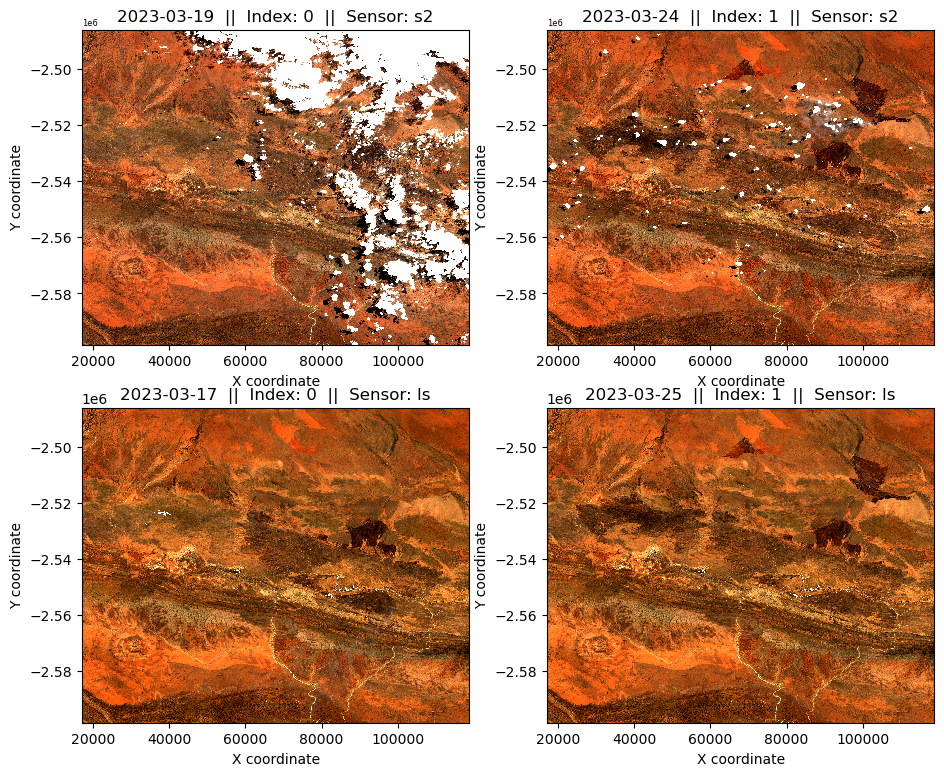

In [8]:
# Return the number of images loaded from the 'near real-time' imagery extracts to the nrt_time_count variable
nrt_s2_count = nrt_s2.dims["time"]
nrt_ls_count = nrt_ls.dims["time"]
nrt_time_count = nrt_s2_count + nrt_ls_count


# Divide the number of images by 2 rounding up to calculate the number of rows for the below figure are needed
nrt_rows = math.ceil(nrt_time_count / 2)

# Construct a figure to visualise the extracted near real-time imagery
f, axarr = plt.subplots(nrt_rows, 2, figsize=(11, nrt_rows * 4.5), squeeze=False)

# Flatten the subplots so they can reasily be enumerated through
axarr = axarr.flatten()

# Plot each sentinel-2 image on a subplot
for t in range(nrt_s2_count):
    rgb(
        nrt_s2.isel(time=t),
        bands=["nbart_red", "nbart_green", "nbart_blue"],
        ax=axarr[t],
    )
    title = (
        str(nrt_s2.time[t].values)[:10] + "  ||  Index: " + str(t) + "  ||  Sensor: s2"
    )
    axarr[t].set_title(title)
    axarr[t].set_xlabel("X coordinate")
    axarr[t].set_ylabel("Y coordinate")
    axarr[t].yaxis.offsetText.set_fontsize(6)
    axarr[t].xaxis.offsetText.set_fontsize(6)

# Plot each landsat image on a subplot
for t in range(nrt_ls_count):
    rgb(
        nrt_ls.isel(time=t),
        bands=["nbart_red", "nbart_green", "nbart_blue"],
        ax=axarr[t + nrt_s2_count],
    )
    title = (
        str(nrt_ls.time[t].values)[:10] + "  ||  Index: " + str(t) + "  ||  Sensor: ls"
    )
    axarr[t + nrt_s2_count].set_title(title)
    axarr[t + nrt_s2_count].set_xlabel("X coordinate")
    axarr[t + nrt_s2_count].set_ylabel("Y coordinate")
    axarr[t].yaxis.offsetText.set_fontsize(6)
    axarr[t].xaxis.offsetText.set_fontsize(6)

# Remove the last subplot if an odd number of images are being displayed
if nrt_time_count % 2 != 0:
    f.delaxes(axarr[nrt_time_count])

### Near Real-time Image Selection

From the above images, note the index value of the most appropriate scene and set the `nrt_img_index` variable below to that value. For example, if the first image displayed is the most desirable, set `nrt_img_index` = 0.

Additionally, set the `rt_sensor` variable to the sensor that the chosen near real-time image originated from. s2 for Sentinel-2 or ls for Landsat. Only imagery from the selected collection will be displayed for the baseline image visualisaion below to reduce cross-sensor influence on the analysis. 

In [9]:
# Index selection for the Near Real-time image chosen above. The default value of -1 selects the most recent image regardless of suitability.
nrt_img_index = 1
# Set the below variable to either 's2' or 'ls' depending on the sensor your chosen image is from.
nrt_sensor = "ls"

# Assign the selected image to the rt_img variable, and identify which sensor and measurements to use to find a baseline image.
if nrt_sensor == "s2":
    nrt_img = nrt_s2.isel(time=nrt_img_index)
    baseline_products = ["ga_s2am_ard_3", "ga_s2bm_ard_3"]
    baseline_measurements = measurements_s2
    index_collection = "ga_s2_3"
    baseline_res = s2_res
    baseline_cloud_mask = "s2cloudless"
elif nrt_sensor == "ls":
    nrt_img = nrt_ls.isel(time=nrt_img_index)
    baseline_products = ["ga_ls8c_ard_3", "ga_ls9c_ard_3"]
    baseline_measurements = measurements_ls
    index_collection = "ga_ls_3"
    baseline_res = ls_res
    baseline_cloud_mask = "fmask"
else:
    print(
        "Please make sure the 'nrt_sensor' variable is correctly set to either s2 or ls"
    )

## 4. Load and Select baseline Imagery

In [10]:
# Load imagery from whichever collection the NRT image was selected from.
baseline = load_ard(
    dc=dc,
    products=baseline_products,
    time=(baseline_start, baseline_end),
    measurements=baseline_measurements,
    min_gooddata=min_gooddata_base,
    resolution=baseline_res,
    cloud_mask=baseline_cloud_mask,
    **query
)

Finding datasets
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Counting good quality pixels for each time step using fmask
Filtering to 3 out of 9 time steps with at least 85.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 3 time steps


### Visualise the extracted baseline imagery

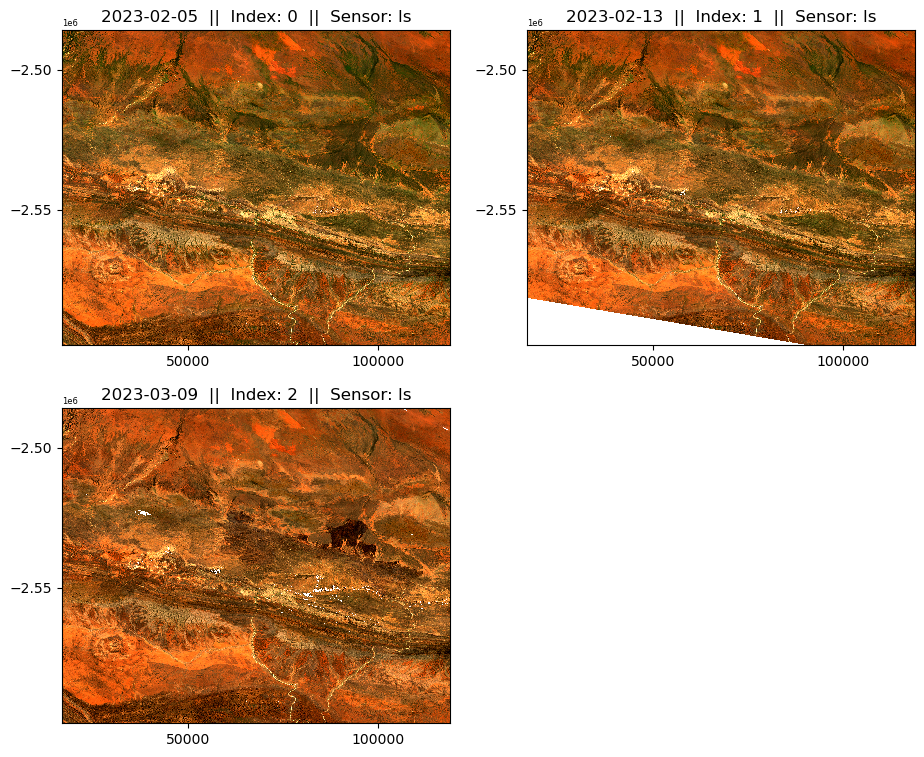

In [11]:
# Return the number of images loaded from the baseline imagery extract to the baseline_count variable
baseline_count = baseline.dims["time"]

# Set number of rows to be used in the visualisation plot depending on the number of returns
baseline_rows = math.ceil(baseline_count / 2)

# Create a figure to plot each potential baseline image
f, axarr = plt.subplots(
    baseline_rows, 2, figsize=(11, (baseline_rows * 4.5)), squeeze=False
)

# Flatten the figure axes to allow simple enumeration
axarr = axarr.flatten()

# Loop through each baseline image and add them to the figure
for t in range(baseline_count):
    rgb(
        baseline.isel(time=t),
        bands=["nbart_red", "nbart_green", "nbart_blue"],
        ax=axarr[t],
        robust=True,
    )
    title = (
        str(baseline.time[t].values)[:10]
        + "  ||  Index: "
        + str(t)
        + "  ||  Sensor: "
        + nrt_sensor
    )
    axarr[t].set_title(title)
    axarr[t].set(xlabel=None)
    axarr[t].set(ylabel=None)
    axarr[t].locator_params(nbins=3)
    axarr[t].yaxis.offsetText.set_fontsize(6)
    axarr[t].xaxis.offsetText.set_fontsize(6)

# Check if an odd number of images have been extracted, and if so, remove the last empty plot from the visualisation.
if baseline_count % 2 != 0:
    f.delaxes(axarr[baseline_count])

### Baseline Image Selection

A baseline image from the above selection must be chosen. It is important to remember that the dNBR index measured environmental changes associated with fire induced landscape change. Therefore, a scene similar to the near real-time image that is free from fire affects will provide the best comparison point to detect burn scars. For example, if the landscape in the near real-time image is dry, it is better to chose a baseline image where the landscape has a similar level of dryness compared to a greener image.

Note the index number of the baseline image chosen above, then set it to the `baseline_img_index` variable.

In [12]:
# Set the baseline_img_index variable to the index of the chosen baseline image
baseline_img_index = 1

# Extract the chosen baseline image to the baseline_img variable
baseline_img = baseline.isel(time=baseline_img_index)

## 5. Calculate NBR and dNBR dataarray's and perform optional post-processing

In [13]:
# Calculate NBR for the near real-time image and assign it to the rt_NBR variable
nrt_image_NBR = calculate_indices(
    nrt_img, index="NBR", collection=index_collection, drop=False
)
nrt_NBR = nrt_image_NBR.NBR

# Calculate NBR for the baseline image and assign it to the baseline_NBR variable
baseline_image_NBR = calculate_indices(
    baseline_img, index="NBR", collection=index_collection, drop=False
)
baseline_NBR = baseline_image_NBR.NBR

# Calculate dNBR (delta NBR) by differeing the two indices
dNBR = baseline_NBR - nrt_NBR

Text(0.5, 1.0, 'Baseline NBR 2023-02-05')

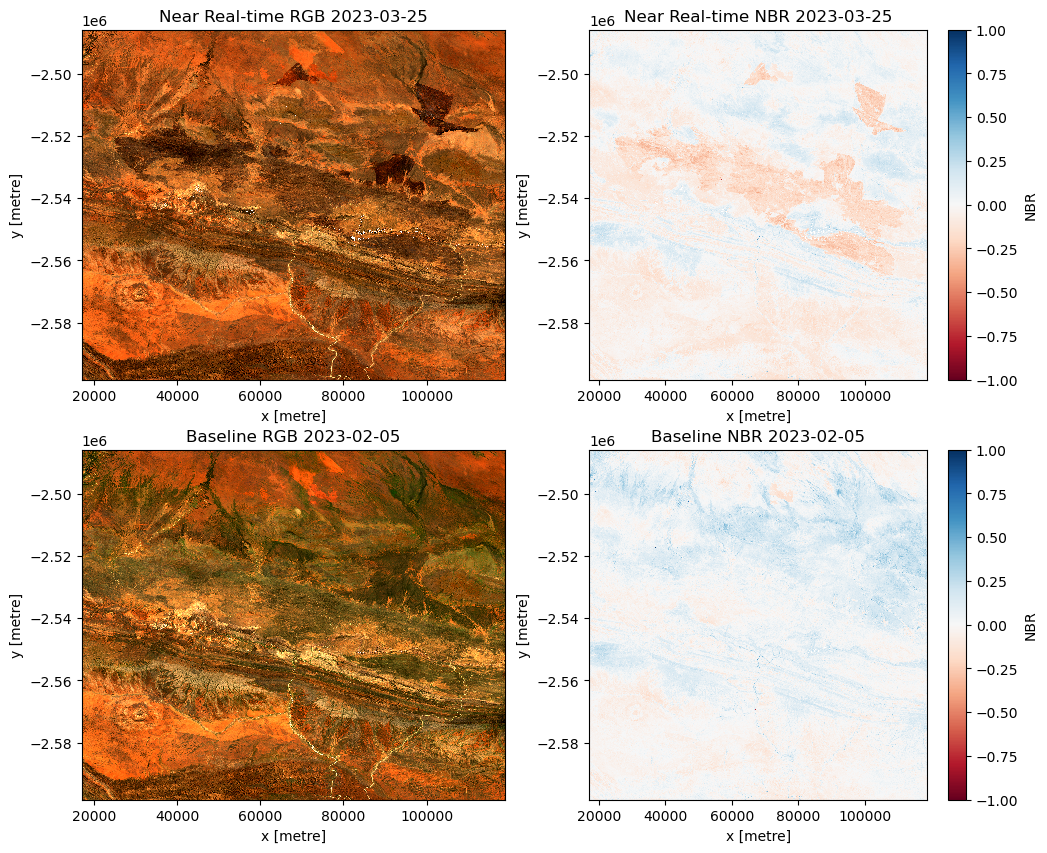

In [14]:
# Create a figure to visualise the selected images in true colour, as well as the NBR index.
f, axarr = plt.subplots(2, 2, figsize=(12, 10), squeeze=False)

# Visualise the selected near real-time and baseline images in true colour
rgb(
    nrt_img,
    bands=["nbart_red", "nbart_green", "nbart_blue"],
    ax=axarr[0, 0],
    robust=True,
)

rgb(
    baseline_img,
    bands=["nbart_red", "nbart_green", "nbart_blue"],
    ax=axarr[1, 0],
    robust=True,
)

# Visualise the NBR index for each image
nrt_NBR.plot(cmap="RdBu", vmin=-1, vmax=1, ax=axarr[0, 1])

baseline_NBR.plot(cmap="RdBu", vmin=-1, vmax=1, ax=axarr[1, 1])

# Set subplot Titles
axarr[0, 0].set_title("Near Real-time RGB " + str(nrt_img.time.values)[:10])
axarr[0, 1].set_title("Near Real-time NBR " + str(nrt_img.time.values)[:10])
axarr[1, 0].set_title("Baseline RGB " + str(baseline_img.time.values)[:10])
axarr[1, 1].set_title("Baseline NBR " + str(baseline_img.time.values)[:10])

### dNBR vs RBR for Burnt Area Mapping

As previously discussed, two differenced fire severity indices are available in this notebook. The default is the delta NBR. However, if the fire in your AOI occurs over less densely vegetated landscapes such as grasslands, you may wish to trial the RBR index.

Depending on your choice of Fire Severity Index, set the `bam_method` variable to either 'dNBR' or 'RBR'.

In [15]:
# set the bam_method variable to either 'dNBR' or 'RBR'.
bam_method = "RBR"

# Calculate the bam variable based on the chosen dFSI
if bam_method == "RBR":
    RBR = dNBR / (baseline_NBR + 1.001)
    bam = RBR

elif bam_method == "dNBR":
    bam = dNBR
else:
    print(
        "Please make sure the 'bam_method' variable is correctly set to either 'RBR' or 'dNBR'"
    )

Text(0.5, 1.0, 'relativized_dNBR measured between 2023-02-05 - 2023-03-25')

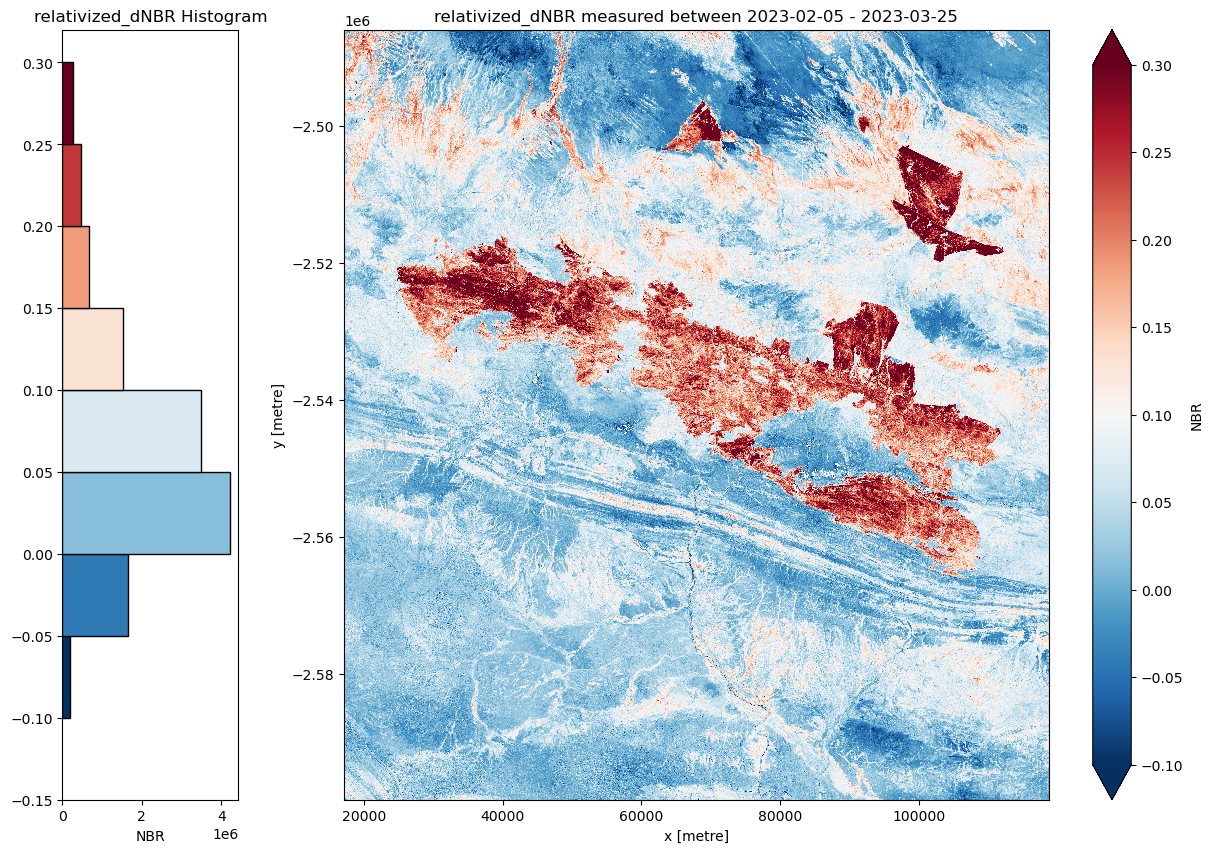

In [16]:
f, axarr = plt.subplots(
    1, 2, figsize=(15, 10), squeeze=False, gridspec_kw={"width_ratios": [1, 5]}
)

# Calculate and round the dNBR dataarray value range to set determine the plots colourmap range
bam_NBR_min = round(float(bam.quantile(0.005)), 1)
bam_NBR_max = round(float(bam.quantile(0.995)), 1)

# PLot the dNBR dataarray on the second subplot of the above figure
bam.plot(
    cmap="RdBu_r", vmin=bam_NBR_min, vmax=bam_NBR_max, ax=axarr[(0, 1)], robust=True
)

# Plot a histogram of dNBR values in the first figure subplot.
# Calculate a colourmap from the dataarray plot by iterating through individual histogram patches
cm = plt.colormaps.get_cmap("RdBu_r")
n, bins, patches = xr.plot.hist(
    darray=bam,
    bins=np.arange(bam_NBR_min, bam_NBR_max + 0.05, 0.05),
    align="mid",
    orientation="horizontal",
    ec="black",
    yticks=(np.arange(bam_NBR_min - 0.05, bam_NBR_max + 0.05, step=0.05)),
    ax=axarr[(0, 0)],
)
# Match the colour scale of the histogram to that used in the map plot.
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, "facecolor", cm(c))

# Set titles for each subplot
axarr[0, 0].set_title(bam_method + " Histogram")
axarr[0, 1].set_title(
    bam_method
    + " measured between "
    + str(baseline_img.time.values)[:10]
    + " - "
    + str(nrt_img.time.values)[:10]
)

### Setting the threshold value to identify burnt areas

A value needs to be chosen to delineate burnt and unburnt areas. THis value can vary depending on the vegetation structure and environmental conditions of the area being mapped. A value of 0.3 could be used as a starting point, however it is helpful to interpret the above histogram and dNBR plot to help determine the most suitable value for your AOI. The selection of a threshold value involves compromise between a value that is so low that false returns are included, and high enough that low-severity and less vegetated burnt areas are excluded.

Set the chosen threshold value to the `threshold` variable below.

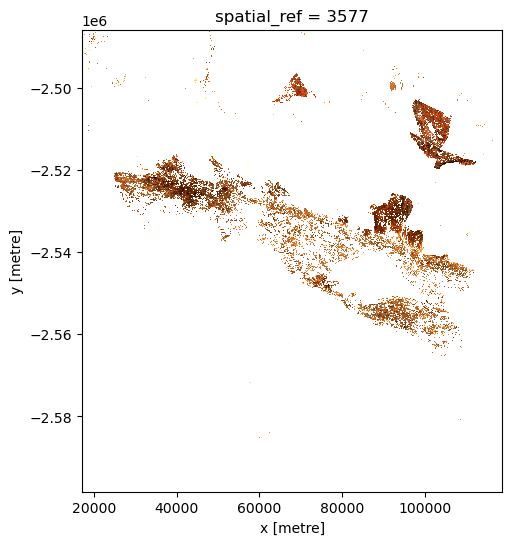

In [59]:
# Set threshold value. Fire serverity index values below this value will be masked out.
threshold = 0.22

# Apply threshold to the dNBR dataset to create the `burnt` dataset of burnt pixels
burnt = bam > threshold

# Mask real-time true colour image with the above `burnt` mask to show what has been captured as burnt area.
masked = bam.where(burnt == 1)
bands = ["nbart_red", "nbart_green", "nbart_blue"]
rgb(nrt_img.where(burnt == 1), bands=bands)

### Optional: Morphological Post-Processing

The result of our analysis may have resulted in an unacceptable amount of isolated pixels and other noisy returns. We can apply morphological operations to the binary xr dataarray ro remove this from the products and simplify the geometry of the output polygons. This step is optional, but can be useful when the analysis produces noisy and 'speckled' outputs.

Closing, Erosion, and Dilation operations are called below. Closing is a compound operation of a dilation followed by an erosion to remove small holes. Erosion shrinks the image pixels, helping to remove noisy and isolated returns. Dilatation extends image pixels to remove small holes and otherwise simplify the geometry of the derived polygons.

These operations are carried out using a disk structuring element. A default size of 3 pixels is used below, but this value can be altered to vary the degree of post-processing applied.

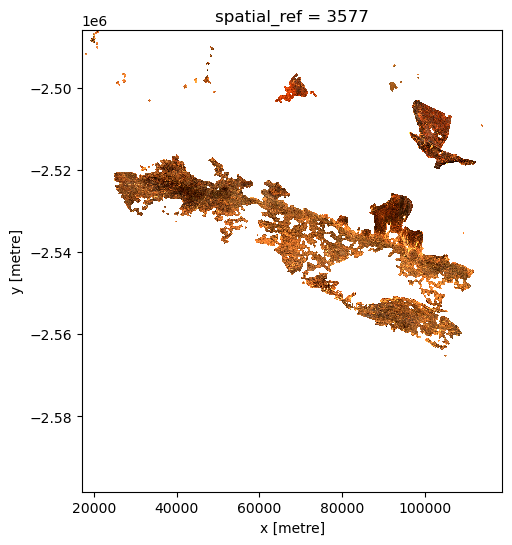

In [60]:
# Define the size of the disk structuring element, measured in number of pixels. The default value is 3.
disk_size = 7

# Perform the Closing, Erosion, and Dilation operations to the burnt dataarray
dilated_data = xr.DataArray(
    morphology.binary_closing(burnt, morphology.disk(disk_size)), coords=burnt.coords
)
erroded_data = xr.DataArray(
    morphology.erosion(dilated_data, morphology.disk(disk_size)), coords=burnt.coords
)
dilated_data = xr.DataArray(
    ndimage.binary_dilation(erroded_data, morphology.disk(disk_size)),
    coords=burnt.coords,
)

# Save the results to the burnt variable
burnt = dilated_data

# Visualise the post-processed dataarray to show the final burnt area
rgb(nrt_img.where(dilated_data == 1), bands=bands)

## 6. Convert raster data to vector and export products

### Exporting Rasters
Three rasters are exported below:
    1. An RGB geotiff of the Near Real-time imagery
    2. An RGB geotiff of the baseline imagery
    3. An unmasked single-band geotiff of the chosen delta NBR index
        - Those wanting to clip these images to the delineated burnt area can use the below shapfile.
    

In [51]:
# Write near real-time fire image to multi-band GeoTIFF
cog.write_cog(
    geo_im=nrt_img.to_array(),
    fname=f"{area_name}_near_realtime_image.tif",
    overwrite=True,
)

# Write baseline reference image to multi-band GeoTIFF
cog.write_cog(
    geo_im=baseline_img.to_array(),
    fname=f"{area_name}_baseline_image.tif",
    overwrite=True,
)

# Turn delta NBR into a Xarray Dataset for export to GeoTIFF
cog.write_cog(geo_im=bam, fname=f"{area_name}_{bam_method}.tif", overwrite=True)

PosixPath('MacDonnell Ranges NT_relativized_dNBR.tif')

### Converting the Raster BAM data to Vector format before exporting to shapefile
We will convert the raster dataarray into vectory format using the xr_vectorize tool and export it to a shapefile. The shapefile will be visualised below.

Exporting vector data to MacDonnell Ranges NT_relativized_dNBR.shp


Text(0.5, 1.0, 'Vectorised Unverified Burnt Area Polygon for \nMacDonnell Ranges NT measured on 2023-03-25')

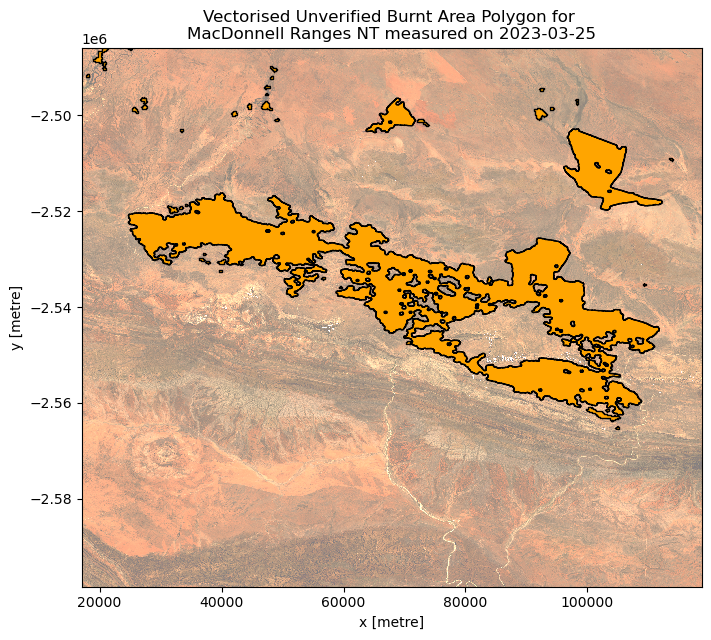

In [61]:
# Convert the burnt area from raster to vector format
gdf = xr_vectorize(
    da=burnt, mask=burnt.values == 1, output_path=f"{area_name}_{bam_method}.shp"
)

# Plot the vector data overlying a transparent NRT RGB Imagery
f, ax = plt.subplots(figsize=(8, 7))

gdf.plot(edgecolor="black", color="orange", ax=ax)

rgb(nrt_img, bands=["nbart_red", "nbart_green", "nbart_blue"], ax=ax, alpha=0.5)

ax.set_title(
    f"Vectorised Unverified Burnt Area Polygon for \n{area_name} measured on "
    + str(nrt_img.time.values)[:10]
)